In [1]:
import csv
import numpy as np
import logging
import matplotlib.pyplot as plt
from imp import reload
reload(logging)

<module 'logging' from 'D:\\Anaconda3\\lib\\logging\\__init__.py'>

# Anomaly Detection by Moving Median
Before we move on to use the global statistics, I want to examine the performance of the detector using moving median instead of moving average. The moving median method provides a more robust estimate of the trend compare to the moving average method. The effect of the anomalies on the moving median method is less severe than the moving average method.

In [11]:
%%capture

reload(logging)
logging.basicConfig(filename='anomaly_median_final.log', filemode='w', level=logging.DEBUG)
with open('task_data_small.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    
    merchant_dict = {} # store the merchant ID under each account
    amount_dict = {} # store the transaction amount for corresponding merchant ID under each account
    median_dict = {} # store the moving median under each account
    std_dict = {} # store the moving standard deviation under each account
    anomaly_median_dict = {} # store the index of anomaly transactions under each account
    account_count_dict = {} # count the number of uncorrupted transactions under rach account
    
    anomaly_median_count = 0 # count the total number of anomalies
    
    for row in csv_reader:
        print("====================")
        
        # first ensure only the data that is not corrupted is processed
        if len(row)==3 and row[0]!='' and row[1]!='' and row[2]!='' and row[0]!='X' and row[1]!='X' and row[2]!='X': 
            account = row[0].strip() # account ID
            merchant = row[1].strip() # merchant ID
            amount = float(row[2]) # transaction amount
            print("Account: "+account)
            print("Merchant: "+merchant)
            print("Transaction amount: "+row[2])
            
            # current account appeared before
            if account in merchant_dict:
                current_median = median_dict[account][-1]
                current_std = std_dict[account][-1]
                diff = amount - current_median
                
                account_count_dict[account] += 1
                
                merchant_dict[account].append(merchant)
                amount_dict[account].append(amount)

                new_median = np.median(amount_dict[account])
                new_std = np.std(amount_dict[account])
                median_dict[account].append(new_median)
                std_dict[account].append(new_std)
                print("Median of transaction amount so far: "+str(new_median))
                print("Std of transaction amount so far: "+str(new_std))
                
                # there is only one transaction for the current account, or the current transaction is not flagged up
                # because it does not deviate from the current median for more than 3 std
                if (len(std_dict[account])==2 and current_std==0) or (diff>=-3*current_std and diff<=3*current_std):
                    print("Status: normal")
                
                # current transaction is flagged up because it deviates from the current mean for more than 3 std
                else:
                    anomaly_median_count += 1
                    
                    if account in anomaly_median_dict:
                        anomaly_median_dict[account].append(account_count_dict[account])
                    else:
                        anomaly_median_dict[account]=[account_count_dict[account]]
                    
                    #logging.basicConfig(filename='anomaly_median2.log',level=logging.DEBUG)
                    logging.warning('Flag: '+'account: '+account+' merchant: '+merchant+' amount: '+str(amount))
                    print("Status: abnormal. The event has been recorded in log file.")
                    
            
            # first time seeing the current account
            else:
                print("Median of transaction amount so far: "+str(amount))
                print("Std of transaction amount so far: 0")
                print("Status: normal")
        
                merchant_dict[account] = [merchant]
                amount_dict[account] = [amount]
                median_dict[account] = [amount]
                std_dict[account] = [0]
                
                account_count_dict[account]=0
        
        # corrupted data
        else:
            account = row[0].strip() # account ID
            merchant = row[1].strip() # merchant ID
            print("Account: "+account)
            print("Merchant: "+merchant)
            print('The data of this transaction is corrupted' )

# Analysis
The moving median method marked more data as anomalous compared with the moving average method. This is mainly because now we avoid averaging anomalies into the trend, thus the detector is more sensible to data that deviate from the mean by a fairly large margin. 

As a comparison, we show the transactions of the same account 255046487. From the following graph we can see there is one more anomaly detected by the moving median method compared with the moving average method. The 6th transaction is also marked as anomalous, which is more sensible when looking at the transaction curve.

In [12]:
print('There are '+str(anomaly_median_count)+' anomalies recorded.') # number of anomalies recorded

There are 17658 anomalies recorded.


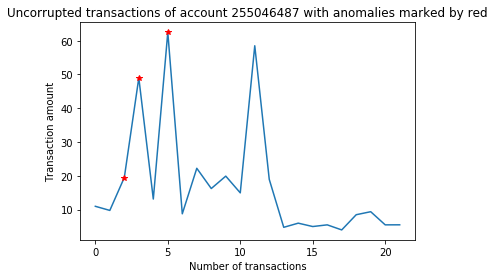

In [13]:
account = '255046487'
plt.plot(amount_dict[account]) # print all the transactions 
plt.title('Uncorrupted transactions of account '+account+' with anomalies marked by red')
plt.xlabel('Number of transactions')
plt.ylabel('Transaction amount')
if account in anomaly_median_dict: # if the account has anomalies, mark them by red points
    for i in range(len(anomaly_median_dict[account])):
        plt.plot(anomaly_median_dict[account][i], amount_dict[account][anomaly_median_dict[account][i]], 'r*')